In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from utils.train_util import ClassicTrainer, ADGTrainer
from utils.data_util import dataset, dataset_CADG

data_path = 'data/'

In [2]:
CAND_COLORS = np.array(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f',
                '#ff7f00','#cab2d6','#6a3d9a', '#90ee90', '#9B870C', '#2f4554',
                '#61a0a8', '#d48265', '#c23531'])

In [3]:
# pick the domains with enough cells to visualize
def valid(domains, cutoff):
    ds = np.unique(domains)
    if ds.shape[0]<2:
        return False
    valid_domain_count = 0 # number of domain with more than cutoff samples
    for d in ds:
        if np.where(domains==d)[0].shape[0] >= cutoff:
            valid_domain_count += 1
    if valid_domain_count < 2:
        return False
    return True

In [4]:
# plot pca visualization for certain domains with cell types colored
def plot_pca_ct(representations, labels, domains, modelname, expname='scquery', cutoff=20):
    if not os.path.exists('eval/%s/%s/pca2/'%(expname, modelname)):
        os.mkdir('eval/%s/%s/pca2/'%(expname, modelname))
    ndomains = np.unique(domains)
    for z_target in ndomains:
        indeces = np.where((domains==z_target))[0]
        if len(indeces) == 0 or not valid(labels[indeces], cutoff):
            continue
        pca = PCA(n_components=2)
        pca.fit(representations[indeces])
        X_reduced = pca.transform(representations[indeces])
        plt.clf()
        fig, ax = plt.subplots()
        ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=5, alpha=0.6, c=labels[indeces])
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        # plt.show()
        plt.savefig('eval/%s/%s/pca2/%s_%s.png'%(expname, modelname, modelname, d.accessions_set[z_target]))
        plt.close()

In [51]:
# plot the pca visualization for the whole dataset
def plot_pca_all(representations, labels, domains, modelname, expname='scquery', nlabels=39, cutoff=20):
    indeces = np.arange(representations.shape[0])
    pca = PCA(n_components=2)
    pca.fit(representations[indeces])
    X_reduced = pca.transform(representations[indeces])

    plt.clf()
    fig, ax = plt.subplots()
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=5, alpha=0.6, c=CAND_COLORS[-3:][domains[indeces]])
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    plt.savefig('eval/%s/pca_domains_%s.png'%(expname, modelname))
    
    plt.clf()
    fig, ax = plt.subplots()
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=5, alpha=0.6, c=CAND_COLORS[labels[indeces]])
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    plt.savefig('eval/%s/pca_labels_%s.png'%(expname, modelname))


In [5]:
# plot pca visualization for certain cell types with domains colored
def plot_pca(representations, labels, domains, modelname, expname='scquery', nlabels=39, cutoff=20):
    if not os.path.exists('eval/%s/%s/pca/'%(expname, modelname)):
        os.mkdir('eval/%s/%s/pca/'%(expname, modelname))
    for y_target in range(nlabels):
        indeces = np.where((labels==y_target))[0]
        if len(indeces) == 0 or not valid(domains[indeces], cutoff):
            continue
        pca = PCA(n_components=2)
        pca.fit(representations[indeces])
        X_reduced = pca.transform(representations[indeces])

        plt.clf()
        fig, ax = plt.subplots()
        ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=5, alpha=0.6, c=domains[indeces])
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        plt.savefig('eval/%s/%s/pca/%s_%s.png'%(expname, modelname, modelname, id2name[y_target]))
        plt.close()

In [10]:
# extract the representations from NN
def extract_rep(t, d, scDGN=False):
    representations = None
    labels = None
    domains = None
    n_iter = len(d._train_y)//batch_size
    t.D.eval()
    rng_state = np.random.get_state()
    for i in range(n_iter):
        x = d._train_X[i*batch_size:(i+1)*batch_size] 
        y = d._train_y[i*batch_size:(i+1)*batch_size]
        X = Variable(torch.cuda.FloatTensor(x))
        if scDGN:
            z = d._train_acc[i*batch_size:(i+1)*batch_size]
            f_X = t.D(X, X, mode='eval')
        else:
            z = d._train_z[i*batch_size:(i+1)*batch_size]
            f_X = t.D(X, mode='eval')
        if representations is None:
            representations = f_X.cpu().data.numpy()
            labels = y
            domains = z
        else:
            representations = np.concatenate((representations, f_X.cpu().data.numpy()), 0)
            labels = np.concatenate((labels, y), 0)
            domains = np.concatenate((domains, z), 0)

    # last batch
    x = d._train_X[(i+1)*batch_size:] 
    y = d._train_y[(i+1)*batch_size:]
    X = Variable(torch.cuda.FloatTensor(x))
    if scDGN:
        z = d._train_acc[(i+1)*batch_size:]
        f_X = t.D(X, X, mode='eval')
    else:
        z = d._train_z[(i+1)*batch_size:]
        f_X = t.D(X, mode='eval')
    representations = np.concatenate((representations, f_X.cpu().data.numpy()), 0)
    labels = np.concatenate((labels, y), 0)
    domains = np.concatenate((domains, z), 0)
    return representations, labels, domains


## NN and CDGN

In [79]:
#################### Settings ##############################
num_epochs = 100
batch_size = 256
dim1 = 1136
dim2 = 100
dim_domain = 64
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
data_path = 'data/'
model_path = 'ckpts/'

d_dim = 20499
dim_label = 39
dataset_name = 'scquery'
NN_name = 'pancreas1_test_NN'
scDGN_name = 'pancreas1_test_scDGN'
id2name = {int(line.rstrip().split('-')[1]):'_'.join(line.split('-')[0].split()[1:]) for line in open('data/scquery.txt').readlines()}


#################### Settings ##############################

# prepare the dataset
d = dataset(data_path, batch_size, label_size=dim_label, dataset_name=dataset_name, validation=False)
domain_names = d.accessions_set
d_scDGN = dataset_CADG(data_path, batch_size, label_size=dim_label, model_path, dataset_name=dataset_name, validation=False)

# load the models
t_NN.dataset = d_NN
t_NN.load_model(os.path.join(model_path, NN_name,'final_model.ckpt')
t_scDGN.dataset = d_scDGN
t_scDGN.load_model(os.path.join(model_path, scDGN_name,'final_model.ckpt')

loading dataset...
loading dataset...
loading dataset: pancreas5
ClassicNN(
  (h1): Sequential(
    (0): Linear(in_features=3000, out_features=1136, bias=True)
    (1): Tanh()
  )
  (h2): Sequential(
    (0): Linear(in_features=1136, out_features=100, bias=True)
    (1): Tanh()
  )
  (o): Sequential(
    (0): Linear(in_features=100, out_features=13, bias=True)
  )
)
DANN_Siamese(
  (feature_extractor): Sequential(
    (0): Linear(in_features=3000, out_features=1136, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1136, out_features=100, bias=True)
    (3): Tanh()
  )
  (domain_classifier): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
  )
  (label_classifier): Sequential(
    (0): Linear(in_features=100, out_features=13, bias=True)
  )
)


In [80]:
# extract the representations
NN_representations, NN_labels, NN_domains = extract_rep(t, d, scDGN=False)
scDGN_representations, scDGN_labels, scDGN_domains = extract_rep(t_scDGN, d_scDGN, scDGN=True)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

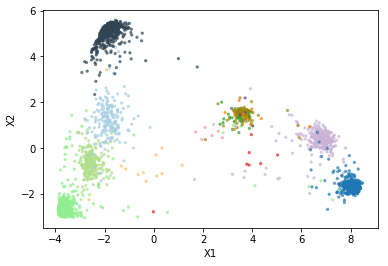

In [81]:
if not os.path.exists('eval/%s/'%dataset_name):
    os.mkdir('eval/%s/NN'%dataset_name)
    os.mkdir('eval/%s/scDGn'%dataset_name)
plot_pca(NN_representations, NN_labels, NN_domains, 'NN', expname=dataset_name)
plot_pca_ct(NN_representations, NN_labels, NN_domains, 'NN', expname=dataset_name)
plot_tsne(NN_representations, NN_labels, NN_domains, 'NN', cutoff=5, expname=dataset_name)
plot_pca_all(NN_representations, NN_labels, NN_domains, 'NN', expname=dataset_name)
plot_pca(scDGN_representations, scDGN_labels, scDGN_domains, 'scDGN', expname=dataset_name)
plot_pca_ct(scDGN_representations, scDGN_labels, scDGN_domains, 'scDGN', expname=dataset_name)
plot_tsne(scDGN_representations, scDGN_labels, scDGN_domains, 'scDGN', cutoff=5, expname=dataset_name)
plot_pca_all(scDGN_representations, scDGN_labels, scDGN_domains, 'scDGN', expname=dataset_name)